## Health Insurance Cost Prediction using Regression Algorithm

In [1]:
# Lodaing the necessary Libraries.
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

pd.plotting.register_matplotlib_converters()
%matplotlib inline
plt.style.use('seaborn-whitegrid')
pd.set_option('display.max_columns', 500)
warnings.filterwarnings("ignore")

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

C:\Users\basan\AppData\Local\Temp\ipykernel_28068\3370625370.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


## 2. Loading the Data

In [2]:
data = pd.read_csv('C:/Users/basan/Downloads/Health_insurance.csv')
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## 3. Exploratory Data Analysis:

In [3]:
print(f'Shape of the data: {data.shape}')
print(f'There are {data.shape[0]} rows in the data.')

Shape of the data: (1338, 7)
There are 1338 rows in the data.


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [5]:
# What are the different datatypes present in the data?
data.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

In [6]:
# Let's check out individual columns:
data.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

In [7]:
# Transform the Index object to a series, and grouping by data types:
g = data.columns.to_series().groupby(data.dtypes).groups
g

{int64: ['age', 'children'], float64: ['bmi', 'charges'], object: ['sex', 'smoker', 'region']}

In [8]:
# let's create a dictionary containing various datatypes (Integer, Float and object) and the columns that have this datatype:
dt = {k.name: v for k, v in g.items()}
# Display the columns by different datatypes:
attributes_by_datatype = pd.DataFrame(list(dt.values()), index = dt.keys(), columns = ['Attr 1', 'Attr 2', 'Attr 3'])
attributes_by_datatype

,Attr 1,Attr 2,Attr 3
int64,age,children,None
float64,bmi,charges,None
object,sex,smoker,region


In [9]:
# Unique values for 'children':
sorted(data['children'].unique())

[0, 1, 2, 3, 4, 5]

## 3.3. Data Cleaning:

In [10]:
data.isnull().any()

age         False
sex         False
bmi         False
children    False
smoker      False
region      False
charges     False
dtype: bool

In [11]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


In [12]:
# Let's construct a function that shows the summary and density distribution of a numerical attribute:
def summary(x):
    x_min = data[x].min()
    x_max = data[x].max()
    Q1 = data[x].quantile(0.25)
    Q2 = data[x].quantile(0.50)
    Q3 = data[x].quantile(0.75)
    print(f'5 Point Summary of {x.capitalize()} Attribute:\n'
          f'{x.capitalize()}(min) : {x_min}\n'
          f'Q1                    : {Q1}\n'
          f'Q2(Median)            : {Q2}\n'
          f'Q3                    : {Q3}\n'
          f'{x.capitalize()}(max) : {x_max}')

    fig = plt.figure(figsize=(16, 10))
    plt.subplots_adjust(hspace = 0.6)
    sns.set_palette('pastel')
    
    plt.subplot(221)
    ax1 = sns.distplot(data[x], color = 'r')
    plt.title(f'{x.capitalize()} Density Distribution')
    
    plt.subplot(222)
    ax2 = sns.violinplot(x = data[x], palette = 'Accent', split = True)
    plt.title(f'{x.capitalize()} Violinplot')
    
    plt.subplot(223)
    ax2 = sns.boxplot(x=data[x], palette = 'cool', width=0.7, linewidth=0.6)
    plt.title(f'{x.capitalize()} Boxplot')
    
    plt.subplot(224)
    ax3 = sns.kdeplot(data[x], cumulative=True)
    plt.title(f'{x.capitalize()} Cumulative Density Distribution')
    
    plt.show()

In [15]:
# Let's take a closer look at the Boxplot, and calculate the measure of skewness and totalnumber of outlier values for various attributes through a function:

def box_plot(x = 'bmi'):
    def add_values(bp, ax):
        """ This actually adds the numbers to the various points of the boxplots"""
        for element in ['whiskers', 'medians', 'caps']:
            for line in bp[element]:
                # Get the position of the element. y is the label you want
                (x_l, y),(x_r, _) = line.get_xydata()
                # Make sure datapoints exist 
                # (I've been working with intervals, should not be problem for this case)
                if not np.isnan(y): 
                    x_line_center = x_l + (x_r - x_l)/2
                    y_line_center = y  # Since it's a line and it's horisontal
                    # overlay the value:  on the line, from center to right
                    ax.text(x_line_center, y_line_center, # Position
                            '%.2f' % y, # Value (3f = 3 decimal float)
                            verticalalignment='center', # Centered vertically with line 
                            fontsize=12, backgroundcolor="white")
    fig, axes = plt.subplots(1, figsize=(4, 8))

    red_diamond = dict(markerfacecolor='r', marker='D')

    bp_dict = data.boxplot(column = x, 
                             grid=True, 
                             figsize=(4, 8), 
                             ax=axes, 
                             vert = True, 
                             notch=False, 
                             widths = 0.7, 
                             showmeans = True, 
                             whis = 1.5,
                             flierprops = red_diamond,
                             boxprops= dict(linewidth=3.0, color='black'),
                             whiskerprops=dict(linewidth=3.0, color='black'),
                             return_type = 'dict')

    add_values(bp_dict, axes)

    plt.title(f'{x.capitalize()} Boxplot', fontsize=16)
    plt.ylabel(f'{x.capitalize()}', fontsize=14)
    plt.show()
    
    skew = data[x].skew()
    Q1 = data[x].quantile(0.25)
    Q3 = data[x].quantile(0.75)
    IQR = Q3 - Q1
    total_outlier_num = ((data[x] < (Q1 - 1.5 * IQR)) | (data[x] > (Q3 + 1.5 * IQR))).sum()
    print(f'Mean {x.capitalize()} = {data[x].mean()}')
    print(f'Median {x.capitalize()} = {data[x].median()}')
    print(f'Skewness of {x}: {skew}.')
    print(f'Total number of outliers in {x} distribution: {total_outlier_num}.') 

## 3.4.1. Age Distribution:

5 Point Summary of Age Attribute:
Age(min) : 18
Q1                    : 27.0
Q2(Median)            : 39.0
Q3                    : 51.0
Age(max) : 64


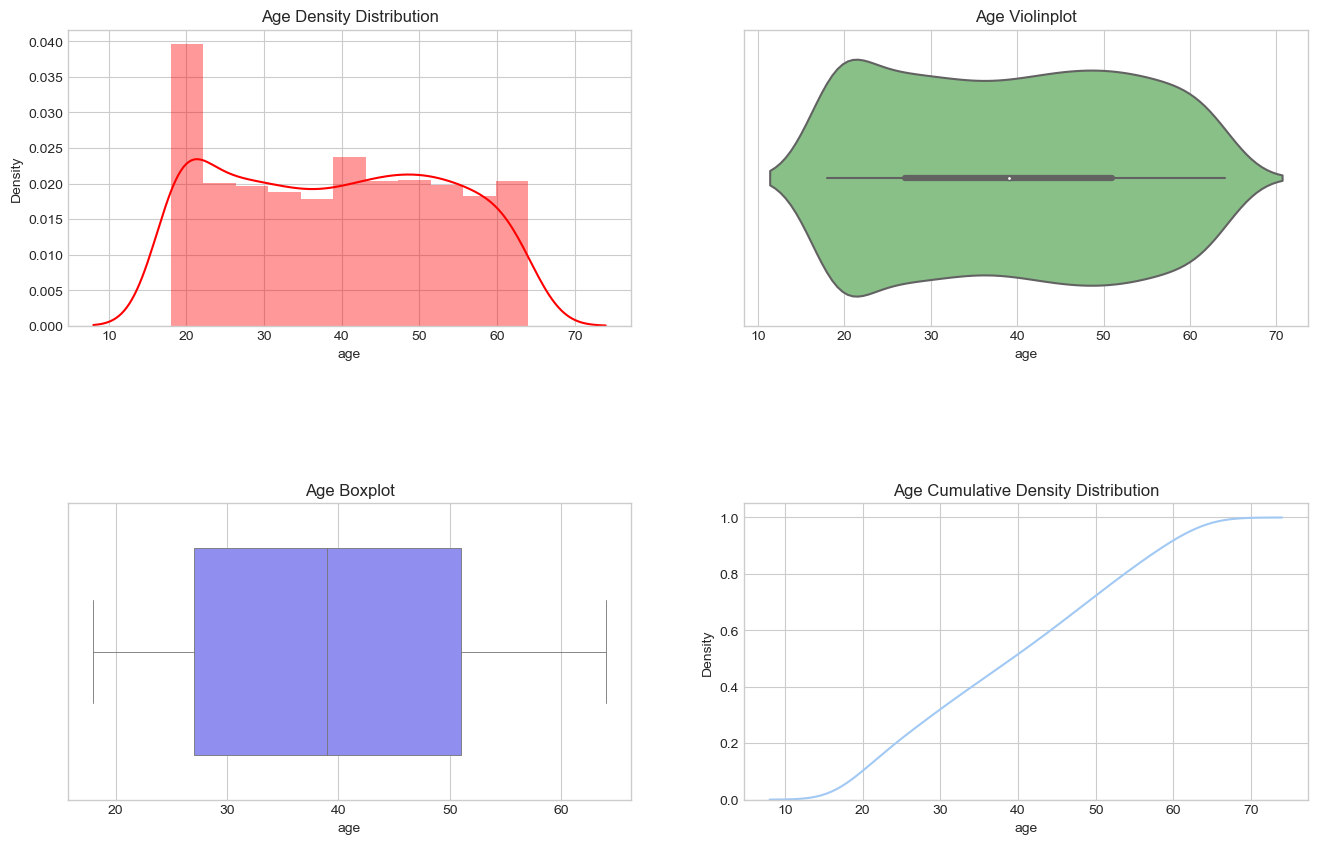

In [16]:
summary('age')

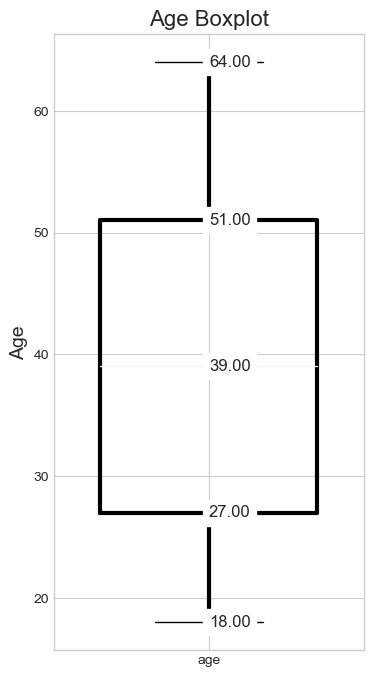

Mean Age = 39.20702541106129
Median Age = 39.0
Skewness of age: 0.05567251565299186.
Total number of outliers in age distribution: 0.


In [17]:
box_plot('age')

In [18]:
# How many of the insured have the age of 64?  
df = data[data['age'] == data['age'].max()]
print(df.head())
print()
print(f'Total number of insured people with the age of 64: {len(df)}.')

     age     sex    bmi  children smoker     region      charges
62    64    male  24.70         1     no  northwest  30166.61817
94    64  female  31.30         2    yes  southwest  47291.05500
199   64  female  39.33         0     no  northeast  14901.51670
328   64  female  33.80         1    yes  southwest  47928.03000
335   64    male  34.50         0     no  southwest  13822.80300

Total number of insured people with the age of 64: 22.


## 3.4.2. BMI Distribution: 

5 Point Summary of Bmi Attribute:
Bmi(min) : 15.96
Q1                    : 26.29625
Q2(Median)            : 30.4
Q3                    : 34.69375
Bmi(max) : 53.13


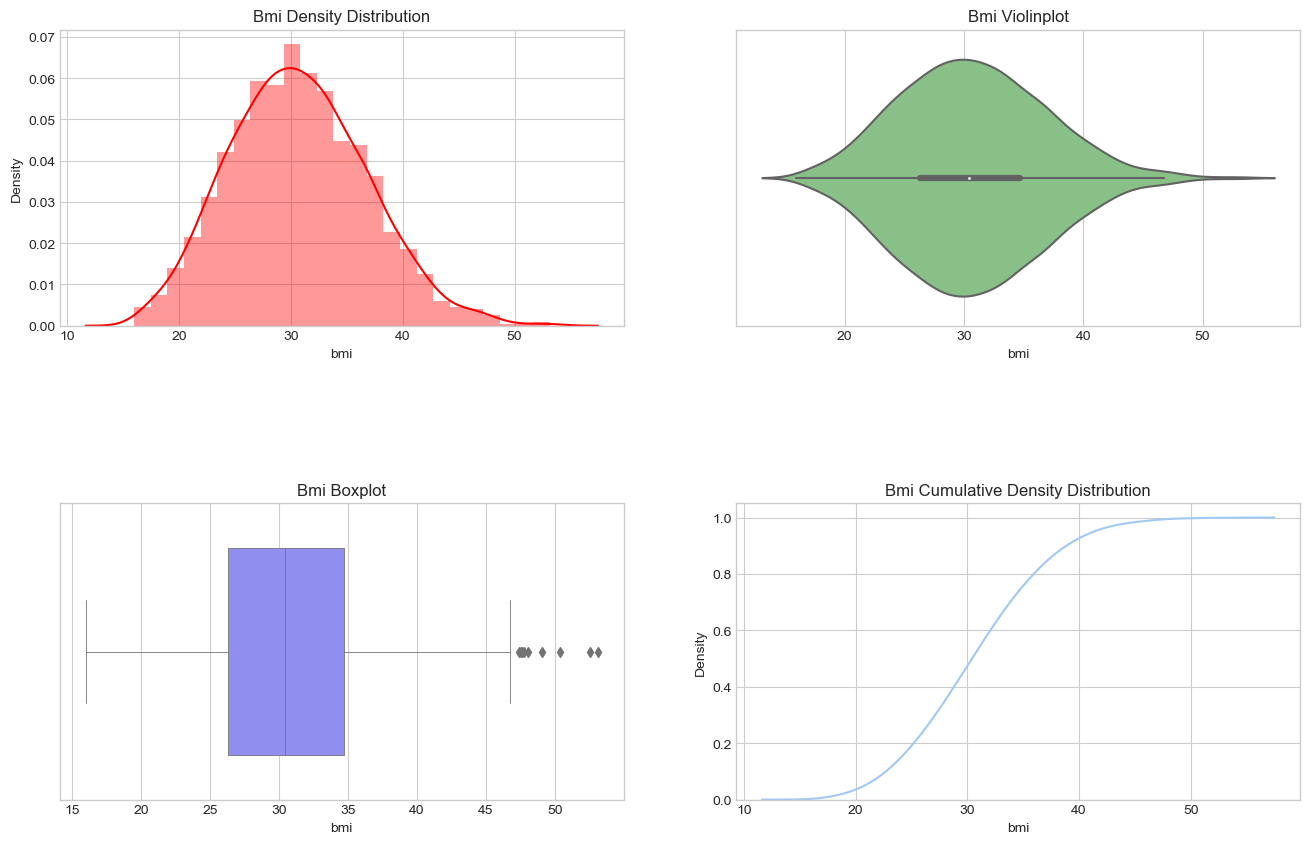

In [19]:
summary('bmi')

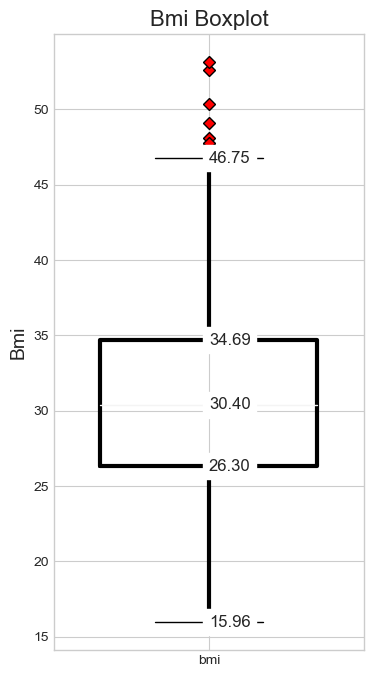

Mean Bmi = 30.66339686098655
Median Bmi = 30.4
Skewness of bmi: 0.2840471105987448.
Total number of outliers in bmi distribution: 9.


In [20]:
box_plot('bmi')

In [21]:
# Who is the insured with the highest BMI, and how does his charges compare to the rest?
data[data['bmi'] == data['bmi'].max()]

,age,sex,bmi,children,smoker,region,charges
1317,18,male,53.13,0,no,southeast,1163.4627


In [22]:
data['charges'].mean(), data['charges'].median()

(13270.422265141257, 9382.033)

## 3.4.3. Charges Distribution:

5 Point Summary of Charges Attribute:
Charges(min) : 1121.8739
Q1                    : 4740.28715
Q2(Median)            : 9382.033
Q3                    : 16639.912515
Charges(max) : 63770.42801


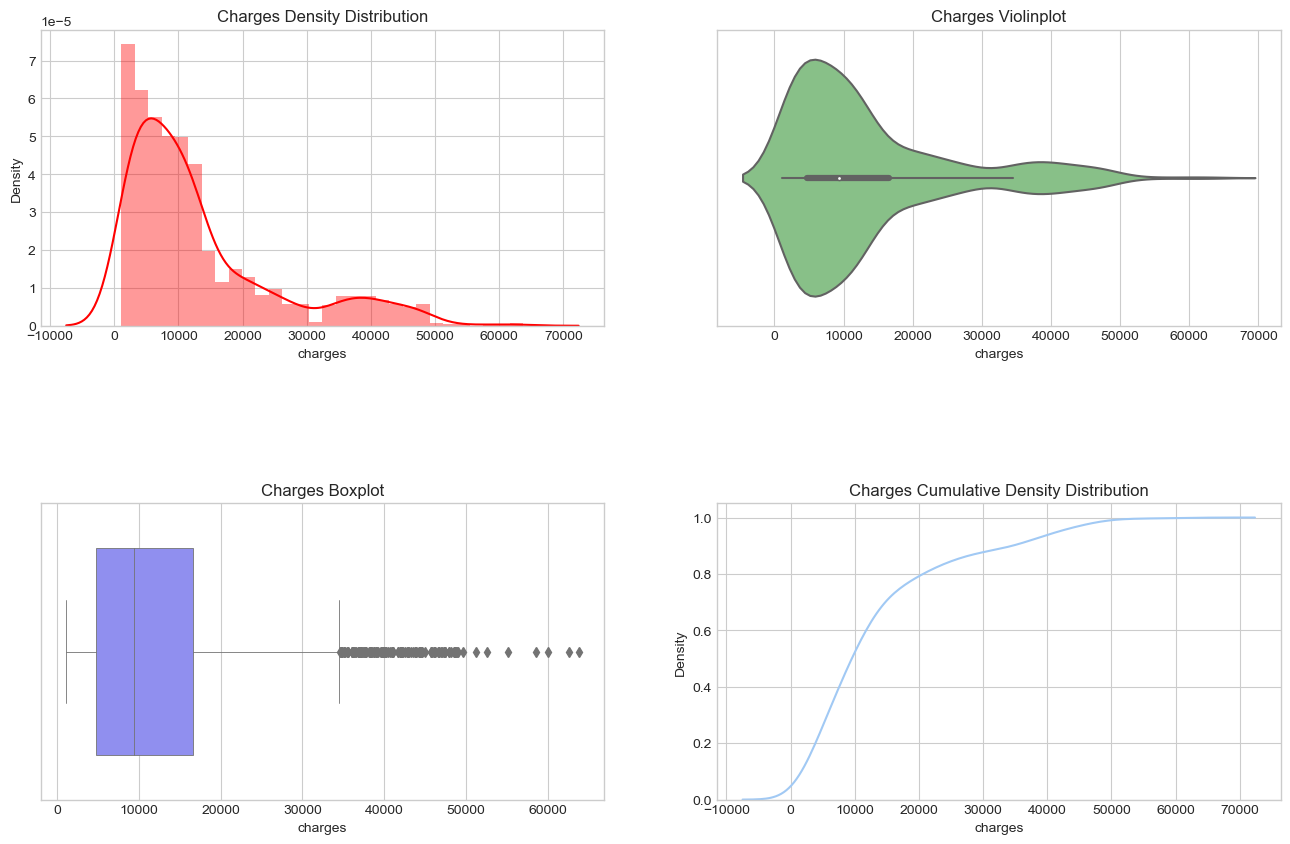

In [23]:
summary('charges')

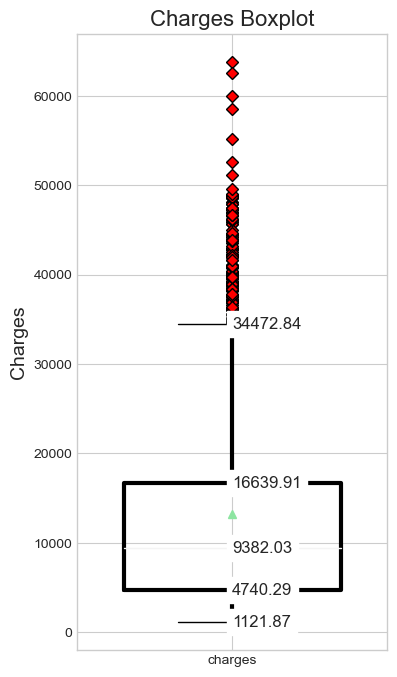

Mean Charges = 13270.422265141257
Median Charges = 9382.033
Skewness of charges: 1.5158796580240388.
Total number of outliers in charges distribution: 139.


In [24]:
box_plot('charges')

In [25]:
# Who is paying the highest charges?
data[data['charges'] == data['charges'].max()]

,age,sex,bmi,children,smoker,region,charges
543,54,female,47.41,0,yes,southeast,63770.42801


In [26]:
# Who is the insured with the highest BMI, and how does his charges compare to the rest?
data[data['bmi'] == data['bmi'].max()]

,age,sex,bmi,children,smoker,region,charges
1317,18,male,53.13,0,no,southeast,1163.4627


In [27]:
data['charges'].mean(), data['charges'].median()

(13270.422265141257, 9382.033)

## 3.5. Summary and Distribution of categorical attributes:

In [28]:
# Create a function that returns a Pie chart for categorical variable:
def pie_chart(x = 'smoker'):
    """
    Function creates a Pie chart for categorical variables.
    """
    fig, ax = plt.subplots(figsize=(8, 6), subplot_kw=dict(aspect="equal"))

    s = data.groupby(x).size()

    mydata_values = s.values.tolist()
    mydata_index = s.index.tolist()

    def func(pct, allvals):
        absolute = int(pct/100.*np.sum(allvals))
        return "{:.1f}%\n({:d})".format(pct, absolute)


    wedges, texts, autotexts = ax.pie(mydata_values, autopct=lambda pct: func(pct, mydata_values),
                                      textprops=dict(color="w"))
    ax.legend(wedges, mydata_index,
              title="Index",
              loc="center left",
              bbox_to_anchor=(1, 0, 0.5, 1))

    plt.setp(autotexts, size=12, weight="bold")

    ax.set_title(f'{x.capitalize()} Piechart')

    plt.show()

## 3.5.1 Sex:

<Axes: xlabel='sex', ylabel='count'>

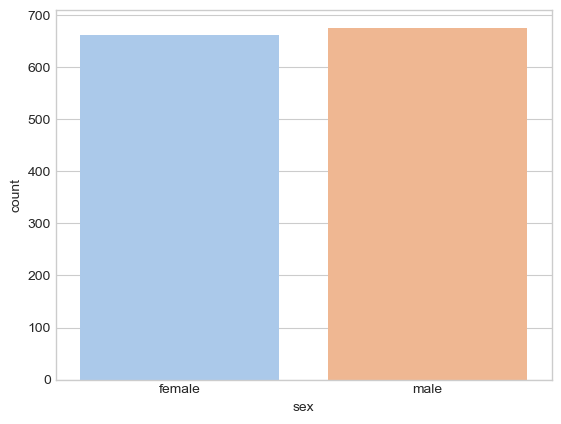

In [29]:
sns.countplot(x = 'sex', data = data)

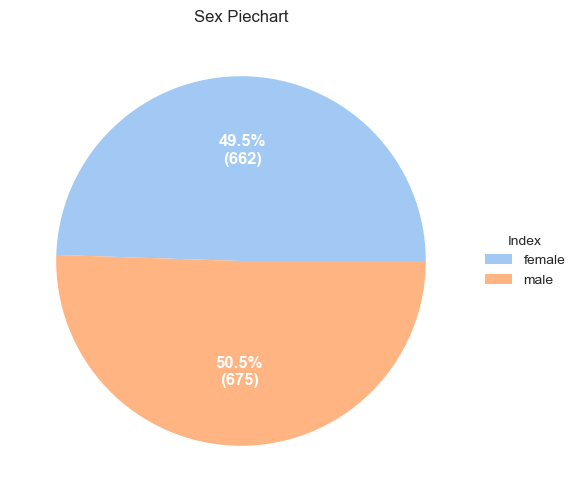

In [30]:
pie_chart('sex')

## 3.5.2. Smoker

<Axes: xlabel='smoker', ylabel='count'>

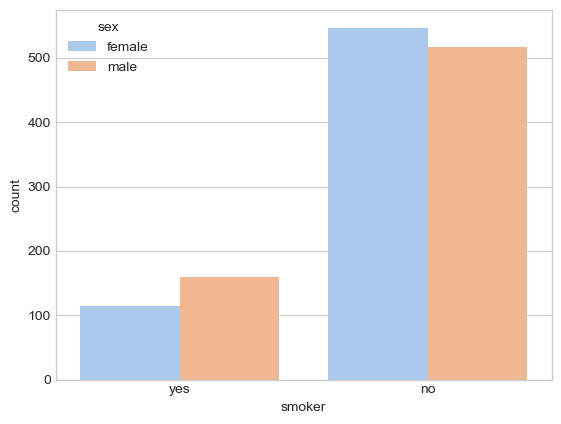

In [31]:
sns.countplot(x = 'smoker', hue = 'sex', data = data)

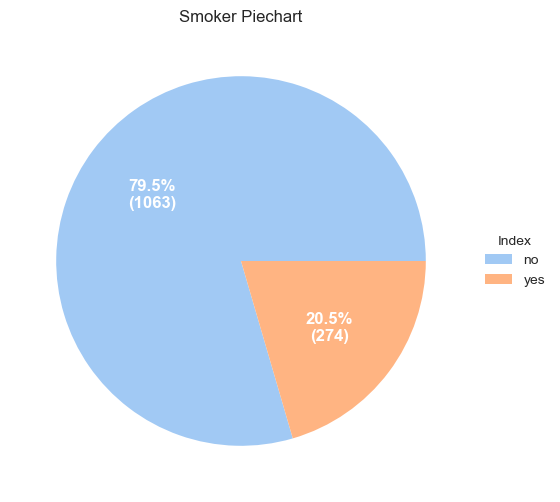

In [32]:
pie_chart('smoker')

In [33]:
# Are average premium charges for smokers significantly higher than non-smokers?
data['charges'].groupby(data['smoker']).mean()

smoker
no      8434.268298
yes    32050.231832
Name: charges, dtype: float64

In [34]:
data.groupby(['smoker', 'sex']).agg('count')

age  bmi  children  region  charges
smoker sex                                        
no     female  547  547       547     547      547
       male    517  517       517     517      517
yes    female  115  115       115     115      115
       male    159  159       159     159      159

<Axes: xlabel='smoker', ylabel='charges'>

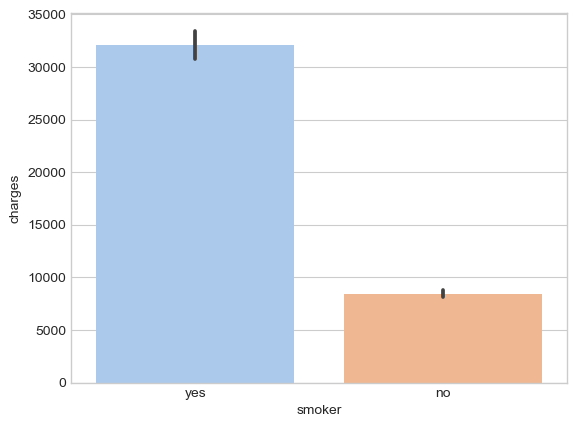

In [35]:
# yes, average premium charges for smokers are indeed significantly higher than non-smokers.
sns.barplot(x = "smoker", y = "charges", data = data)

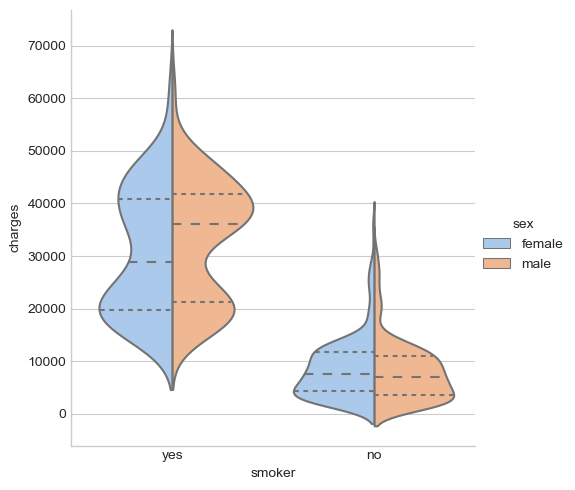

In [36]:
sns.catplot(x="smoker", y="charges", hue="sex",
            kind="violin", inner="quartiles", split=True,
            palette="pastel", data=data);

In [37]:
data.groupby(['smoker', 'sex']).agg('count')['age']

smoker  sex   
no      female    547
        male      517
yes     female    115
        male      159
Name: age, dtype: int64

## 3.5.3. Regions

<Axes: xlabel='region', ylabel='count'>

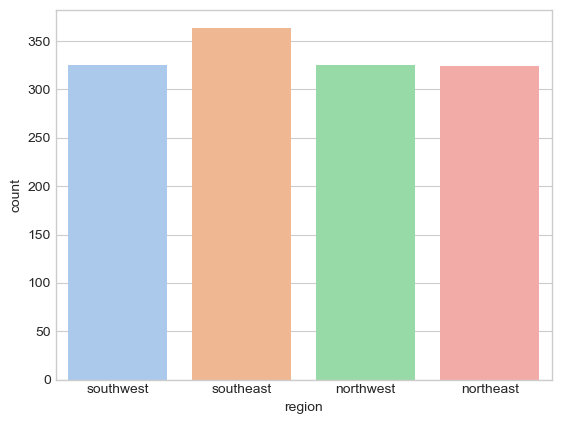

In [38]:
sns.countplot(x = 'region', data = data)

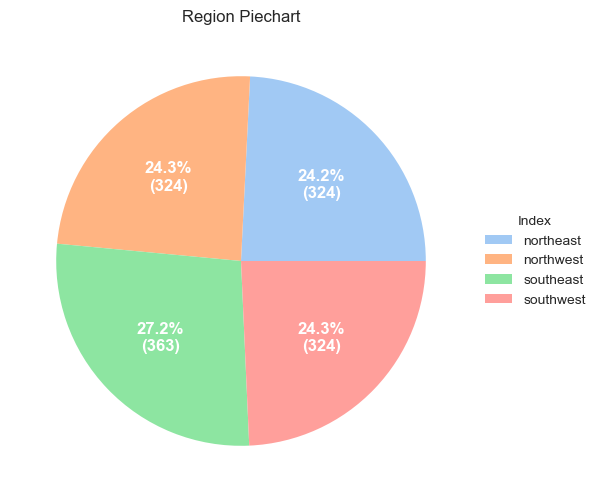

In [39]:
pie_chart('region')

## 3.5.4. Number of Children 

<Axes: xlabel='children', ylabel='count'>

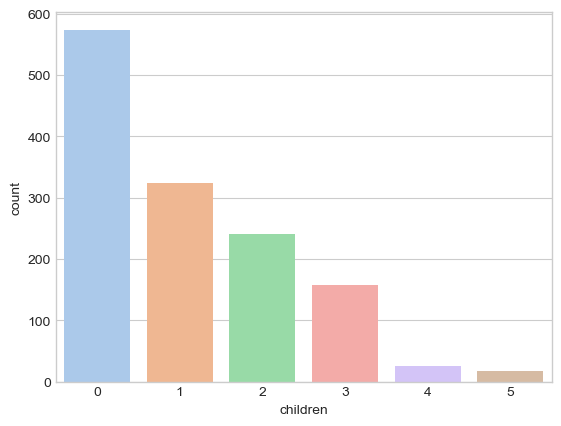

In [40]:
sns.countplot(x = 'children', data = data)

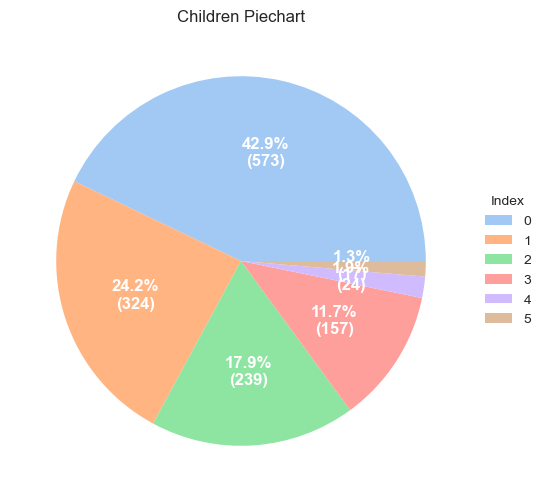

In [41]:
pie_chart('children')

In [42]:
data.groupby(['children']).agg('count')['age']

children
0    574
1    324
2    240
3    157
4     25
5     18
Name: age, dtype: int64

### 3.6. Pairplot:

In [43]:
for x in ['sex', 'children', 'smoker', 'region']:
    data[x] = data[x].astype('category')

data.dtypes 

age            int64
sex         category
bmi          float64
children    category
smoker      category
region      category
charges      float64
dtype: object

In [44]:
type(data.dtypes)

pandas.core.series.Series

In [45]:
# Next, we select all columns of the dataFrame with datatype = category:
cat_columns = data.select_dtypes(['category']).columns
cat_columns

Index(['sex', 'children', 'smoker', 'region'], dtype='object')

In [46]:
# Finally, we transform the original columns by replacing the elements with their category codes:
data[cat_columns] = data[cat_columns].apply(lambda x: x.cat.codes)
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520


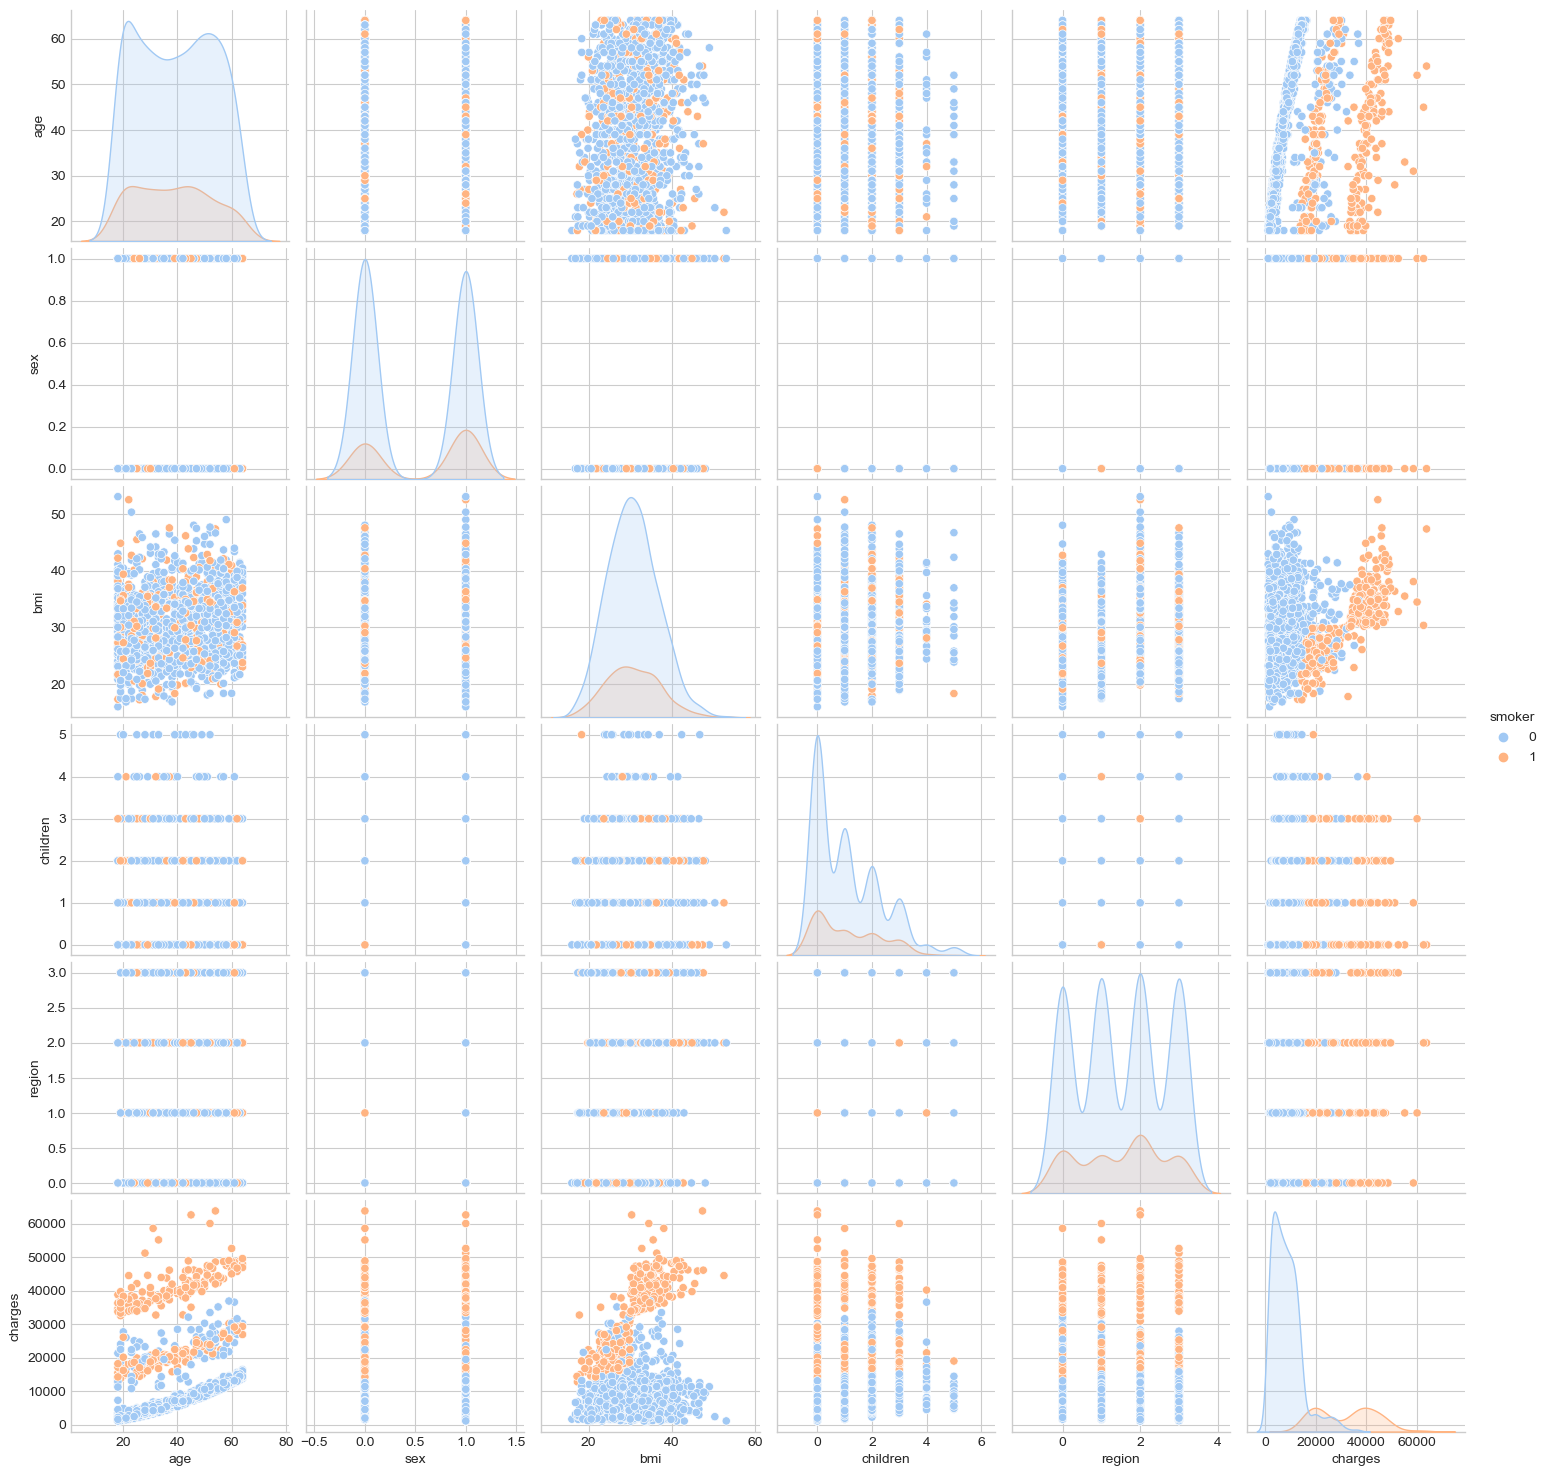

In [47]:
# Now we can plot all columns of our dataset in a pairplot!
sns.pairplot(data, hue  = 'smoker')

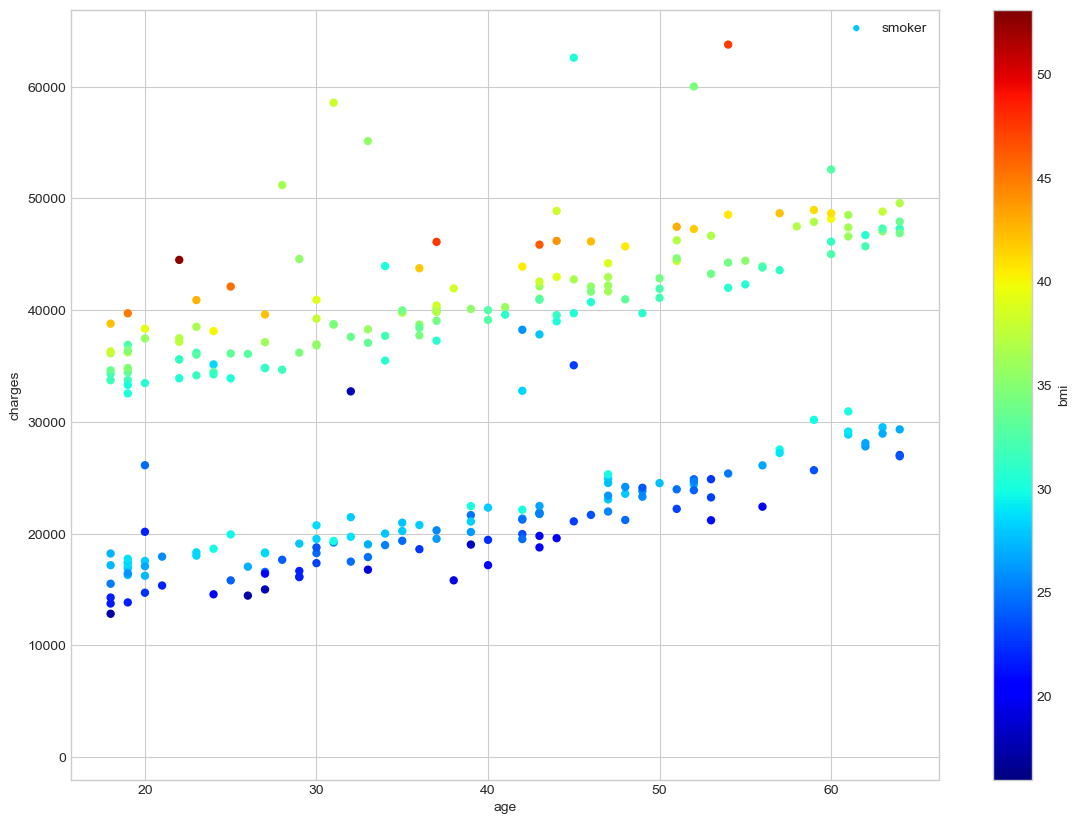

In [48]:
data.plot(kind="scatter", x="age", y="charges", 
    s=data["smoker"]*25, label="smoker", figsize=(14,10),
    c='bmi', cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()

## 3.7. Correlation:

<Axes: >

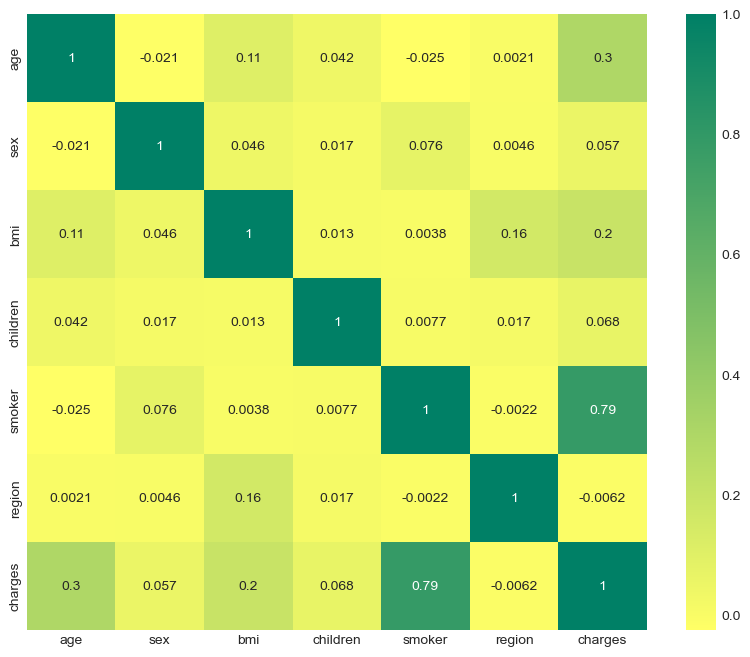

In [49]:
corr = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap = 'summer_r')

In [51]:
#Observation:
#   From the correlation heatmap, we can conclude that the premium charges show a weak positive correlation with Age and BMI of the insured, and a strong positive correlation with smoking habit.

## Linear Regression using K fold Alogrithm

In [52]:
import pandas as pd
import numpy as np
import scipy as sp
import sklearn as sk
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import cross_val_score, KFold
from sklearn import model_selection
from sklearn import linear_model
from sklearn.metrics import mean_squared_error,mean_absolute_error

In [53]:
insurance = pd.read_csv('C:/Users/basan/Downloads/Health_insurance.csv')
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [54]:
def map_smoking(column):
    mapped=[]
    
    for row in column:
        
        if row=="yes":
            mapped.append(1)
        else:
            mapped.append(0)
        
        
    return mapped
insurance["smoker_norm"]=map_smoking(insurance["smoker"])

In [55]:
nonnum_cols=[col for col in insurance.select_dtypes(include=["object"])]

In [56]:
def map_obese(column):
    mapped=[]
    for row in column:
        if row>30:
            mapped.append(1)
        else:
            mapped.append(0)
    return mapped
insurance["obese"]=map_obese(insurance["bmi"])

In [57]:
insurance.head(5)

,age,sex,bmi,children,smoker,region,charges,smoker_norm,obese
0,19,female,27.900,0,yes,southwest,16884.92400,1,0
1,18,male,33.770,1,no,southeast,1725.55230,0,1
2,28,male,33.000,3,no,southeast,4449.46200,0,1
3,33,male,22.705,0,no,northwest,21984.47061,0,0
4,32,male,28.880,0,no,northwest,3866.85520,0,0


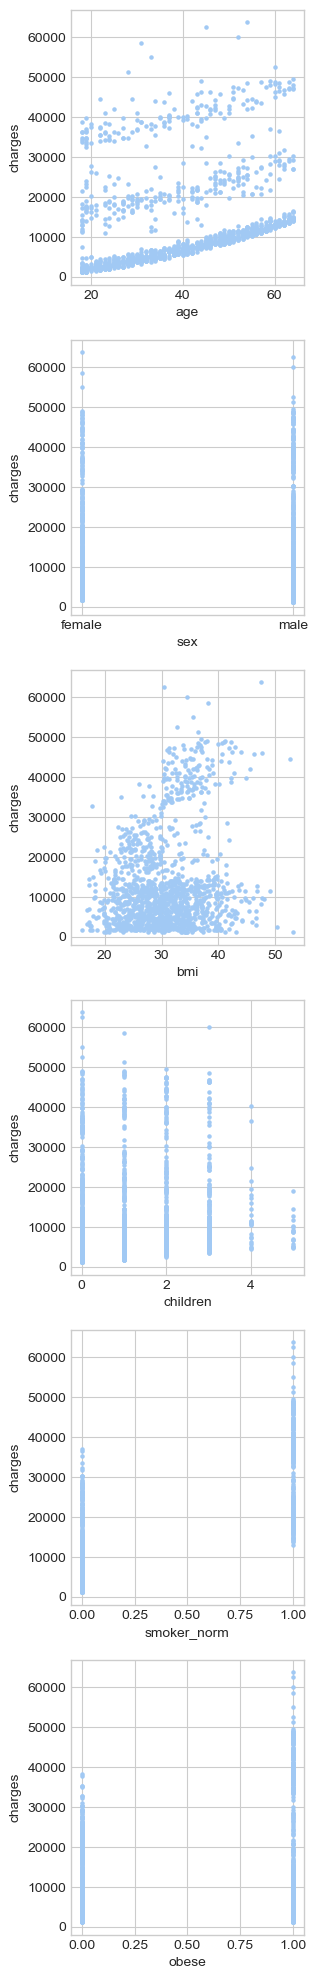

In [59]:
colnum=len(insurance.columns)-3
fig,ax=plt.subplots(colnum,1,figsize=(3,25))
ax[0].set_ylabel("charges")
p_vals={}
for ind,col in enumerate([i for i in insurance.columns if i not in ["smoker","region","charges","sex_norm"]]):
    
    ax[ind].scatter(insurance[col],insurance.charges,s=5)
    ax[ind].set_xlabel(col)
    ax[ind].set_ylabel("charges")  

age :  0.29900819333064765
bmi :  0.19834096883362887
children :  0.0679982268479048
charges :  1.0
smoker_norm :  0.7872514304984773
obese :  0.1996832219958824


Text(0, 0.5, 'Absolute correlation')

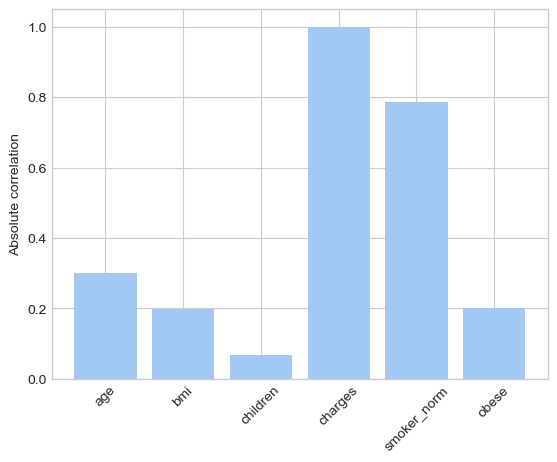

In [60]:
corr_vals=[]
collabel=[]
for col in [i for i in insurance.columns if i not in nonnum_cols]:
    
    p_val=sp.stats.pearsonr(insurance[col],insurance["charges"])
    corr_vals.append(np.abs(p_val[0]))
    print(col,": ",np.abs(p_val[0]))
    collabel.append(col)
plt.bar(range(1,len(corr_vals)+1),corr_vals)
plt.xticks(range(1,len(corr_vals)+1),collabel,rotation=45)
plt.ylabel("Absolute correlation")

In [61]:
cols_not_reg3=['age', 'obese', 'smoker_norm']

In [62]:
seed=2
results = []
names = []

for name, model in models:
    kfold = KFold(10, random_state=None)
    cv_results = cross_val_score(model, insurance[cols_not_reg3], insurance["charges"], cv=kfold)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, np.mean(cv_results), np.std(cv_results))
    print(msg)

NameError: name 'models' is not defined

In [63]:
kf=KFold(n_splits=10, random_state=1, shuffle=True)
intercepts=[]
mses=[]
coefs=[]

for train_index, test_index in kf.split(insurance[cols_not_reg3]):
    
    lr=linear_model.LinearRegression()
    lr.fit(insurance[cols_not_reg3].iloc[train_index],insurance["charges"].iloc[train_index])
    lr_predictions=lr.predict(insurance[cols_not_reg3].iloc[test_index])
    
    lr_mse=mean_squared_error(insurance["charges"].iloc[test_index],lr_predictions)
    
    intercepts.append(lr.intercept_)
    
    coefs.append(lr.coef_)
    mses.append(lr_mse)

In [65]:
rmses=[x**.5 for x in mses]
avg_rmse=np.mean(rmses)
avg_intercept=np.mean(intercepts)
age_coefs=[]
obesity_coefs=[]
smoking_coefs=[]
for vals in coefs:
    #print vals[0]
    age_coefs.append(vals[0])
    obesity_coefs.append(vals[1])
    smoking_coefs.append(vals[2])
age_coef=np.mean(age_coefs)
obesity_coef=np.mean(obesity_coefs)
smoking_coef=np.mean(smoking_coefs)
print("a: ",age_coef," b: ",obesity_coef," c: ",smoking_coef," intercept: ",avg_intercept)

a:  261.83801848327676  b:  4227.7376009403615  c:  23851.06705386572  intercept:  -4107.422133255811


In [66]:
def calculate_insurance(age,obesity,smoking):
    y=(age_coef*age)+(obesity_coef*obesity)+(smoking_coef*smoking)+avg_intercept
    return y

In [67]:
print(calculate_insurance(34,1,1))

32873.875149981686


## Model Comparision using different Linear Regression Algorithm

In [144]:
import pandas as pd
import numpy as np
np.set_printoptions(suppress=True)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import (
    LinearRegression,
    Ridge,
    Lasso,
    ElasticNet,

)
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    PolynomialFeatures,
    StandardScaler,
    LabelEncoder
)
from sklearn.compose import (
    ColumnTransformer,
    make_column_selector,
    )
from sklearn.metrics import mean_squared_error, r2_score
from zipfile import ZipFile
import warnings
warnings.filterwarnings('ignore')

In [145]:
data = pd.read_csv('C:/Users/basan/Downloads/Health_insurance.csv')

In [146]:
styled_data = (
    data.describe()
    .drop("count", axis=0)
    .style.background_gradient(axis=0, cmap="magma")
    .set_properties(**{"text-align": "center"})
    .set_table_styles([{"selector": "th", "props": [("background-color", "k")]}])
    .set_caption("Summary Statistics")
)

In [147]:
styled_data

,age,bmi,children,charges
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


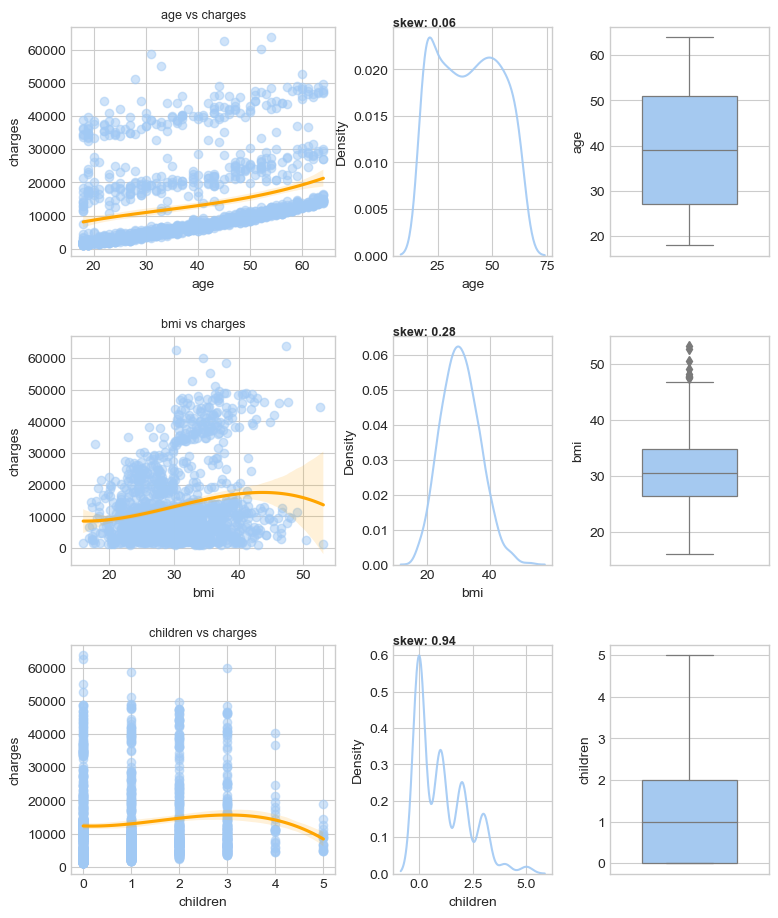

In [148]:
number_columns = data.select_dtypes("number").drop("charges", axis=1)

skewness_before_log = data[number_columns.columns].skew()
fig, axes = plt.subplots(
    nrows=3,
    ncols=3,
    figsize=(9, 11),
    gridspec_kw={"hspace": 0.35, "wspace": 0.3, "width_ratios": [0.5, 0.3, 0.3]},
)
axes = axes.flatten()
i = 0
for column in number_columns.columns:
    ax = axes[i]
    sns.regplot(
        data=data,
        x=column,
        y="charges",
        ax=ax,
        scatter_kws={"alpha": 0.5},
        marker="o",
        line_kws={"color": "orange"},
        order=3,
    )
    ax.set_title(f"{column} vs charges", size=9)
    ax = axes[i + 1]
    sns.kdeplot(data=data, x=column, ax=ax, fill=False, alpha=0.9, legend=True)
    skewness = skewness_before_log[column]
    ax.text(
        ax.get_xlim()[0],
        ax.get_ylim()[-1],
        f"skew: {skewness:.2f}",
        size=9,
        weight="bold",
    )

    ax = axes[i + 2]
    sns.boxplot(
        data=data,
        y=column,
        ax=ax,
        width=0.6,
        saturation=0.9,
        linewidth=0.9,
    )
    i += 3

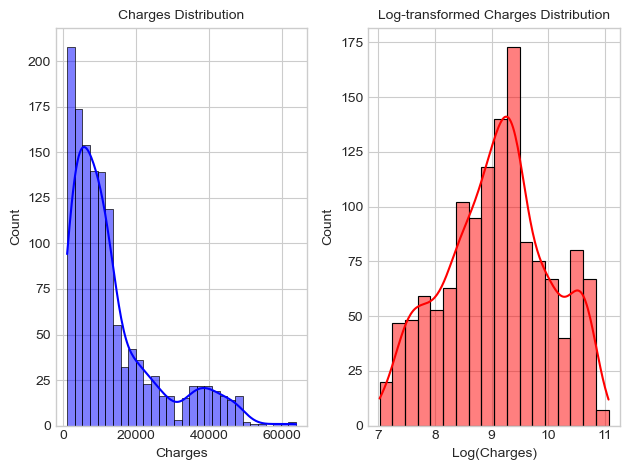

In [149]:
fig = plt.figure()
plt.subplot(121)
sns.histplot(data['charges'], kde=True, color='blue')
plt.title('Charges Distribution', size=10)
plt.xlabel('Charges')

plt.subplot(122)
sns.histplot(np.log(data['charges']), kde=True, color='red')
plt.title('Log-transformed Charges Distribution', size=10)
plt.xlabel('Log(Charges)')
plt.tight_layout()
plt.show()

<Axes: >

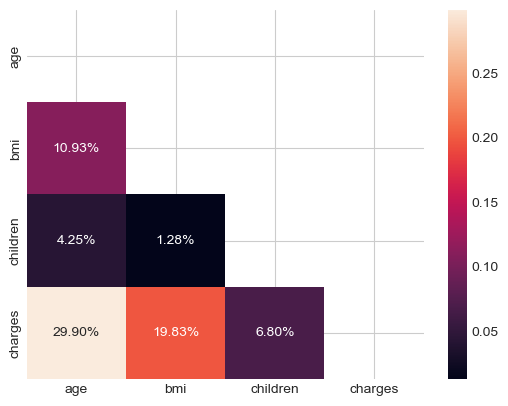

In [150]:
corr = data.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr, mask=mask, annot=True, fmt=".2%")

In [151]:
data["age group"] = pd.cut(data.age, bins=[0, 40, 60, 100], labels=["young adult", "middle-aged", "old adults"])

## Linear Regression Models

In [152]:
X = data.drop(['charges','region'], axis=1)
y = data.charges

X["sex"] = X["sex"].map({"female": 0, "male": 1})
X["smoker"] = X["smoker"].map({"no": 0, "yes": 1})
X["age group"] = X["age group"].map({"young adult": 0, "middle-aged": 1, "old adults": 2})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=23)

In [153]:
def model_pipeline(model, degree=2):
    num_pipeline = Pipeline(
        steps=[
            ("poly", PolynomialFeatures(degree=degree)),
            ("scaler", StandardScaler()),
        ]
    )
    
    
    transformer = ColumnTransformer([
        ("num_transformers", num_pipeline, make_column_selector(dtype_include="number"))
        ], remainder="passthrough")

    model_pipeline = Pipeline(steps=[("transformer", transformer), ("model", model)])
    return model_pipeline

In [154]:
kf = KFold(shuffle=True, random_state=42, n_splits=3)

In [155]:
# Gride Search for Linear Regression
lr = model_pipeline(LinearRegression())
lr_grid = {"transformer__num_transformers__poly__degree": range(0, 6)}

grid_search = GridSearchCV(
    estimator=lr,
    param_grid=lr_grid,
    cv=kf,
    scoring=("r2", "neg_mean_squared_error"),
    refit="r2",
)
grid_search.fit(X_train, y_train)
grid_search.best_score_, grid_search.best_params_

(0.8365898707604331, {'transformer__num_transformers__poly__degree': 2})

In [82]:
best_lr = model_pipeline(
    LinearRegression(),
    degree=grid_search.best_params_["transformer__num_transformers__poly__degree"],
)

best_lr.fit(X_train, y_train)
print("Training score", best_lr.score(X_train, y_train))
print("Testing score", best_lr.score(X_test, y_test))

Training score 0.8434586748166498
Testing score 0.8440829135632232


## Lasso Regression

In [169]:
# Lasso regression
lasso = model_pipeline(Lasso())
lasso_grid = {
    "transformer__num_transformers__poly__degree": range(1, 4),
    "model__alpha": np.geomspace(0.01, 10, 20),
}

grid_search = GridSearchCV(estimator=lasso, param_grid=lasso_grid, cv=kf, refit="r2")
grid_search.fit(X_train, y_train)
grid_search.best_score_, grid_search.best_params_

(0.8367420057246173,
 {'model__alpha': 4.832930238571752,
  'transformer__num_transformers__poly__degree': 2})

In [175]:
best_l1 = model_pipeline(
    Lasso(alpha=grid_search.best_params_["model__alpha"]),
    degree=grid_search.best_params_["transformer__num_transformers__poly__degree"],
)

best_l1.fit(X_train, y_train)
print("Training score", best_l1.score(X_train, y_train))
print("Testing score", best_l1.score(X_test, y_test))

Training score 0.8433381008969295
Testing score 0.8449299997893385


In [157]:
# Ridge Regression
ridge = model_pipeline(Ridge())
ridge_grid = {
    "transformer__num_transformers__poly__degree": range(1, 4),
    "model__alpha": np.geomspace(0.01, 10, 20),
}

grid_search = GridSearchCV(estimator=ridge, param_grid=ridge_grid, cv=kf, refit="r2")
grid_search.fit(X_train, y_train)
grid_search.best_score_, grid_search.best_params_

(0.8366788077179622,
 {'model__alpha': 0.5455594781168517,
  'transformer__num_transformers__poly__degree': 2})

In [158]:
best_l2 = model_pipeline(
    Ridge(alpha=grid_search.best_params_["model__alpha"]),
    degree=grid_search.best_params_["transformer__num_transformers__poly__degree"],
)

best_l2.fit(X_train, y_train)
print("Training score", best_l2.score(X_train, y_train))
print("Testing score", best_l2.score(X_test, y_test))

Training score 0.8434307633120982
Testing score 0.8441526250026632


In [159]:
# Elastic Net
elastic_net = model_pipeline(ElasticNet())
elastic_net_grid = {
    "transformer__num_transformers__poly__degree": range(1, 4),
    "model__alpha": np.geomspace(0.01, 10, 20),
    "model__l1_ratio": np.linspace(0.01, 1, 10),
}


grid_search = GridSearchCV(estimator= elastic_net, param_grid=elastic_net_grid, cv=kf, refit="r2")
grid_search.fit(X_train, y_train)
grid_search.best_score_, grid_search.best_params_

(0.8367420057246173,
 {'model__alpha': 4.832930238571752,
  'model__l1_ratio': 1.0,
  'transformer__num_transformers__poly__degree': 2})

In [160]:
best_elastic_net = model_pipeline(ElasticNet(alpha=grid_search.best_params_["model__alpha"], l1_ratio=grid_search.best_params_["model__l1_ratio"]), degree=grid_search.best_params_["transformer__num_transformers__poly__degree"])
best_elastic_net.fit(X_train, y_train)
print("Training score", best_elastic_net.score(X_train, y_train))
print("Testing score", best_elastic_net.score(X_test, y_test))

Training score 0.8433381008969295
Testing score 0.8449299997893385


## Models Evaluation 

In [171]:
def rmse(ytrue, ypred):
    return np.sqrt(mean_squared_error(ytrue, ypred))

In [172]:
def compare_models(models, X, y):
    evaluate = dict()

    for label, model in models.items():
        ypred = model.predict(X)
        score = (r2_score(y, ypred) * 100).round(2)
        loss = (rmse(y, ypred)).round(2)
        evaluate[label] = [loss, score]
    return evaluate

In [173]:
models = dict(lr = best_lr, ridge=best_l2, elastic_net = best_elastic_net)

train_score_df = pd.DataFrame(compare_models(models, X_train, y_train), index=["rmse", "r2_score"]).T
test_score_df = pd.DataFrame(compare_models(models, X_test, y_test), index=["rmse", "r2_score"]).T

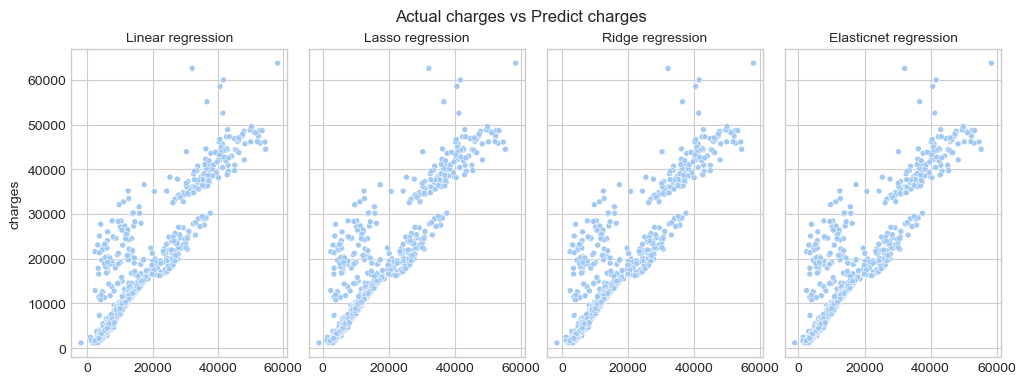

In [176]:
def plot_actual_vs_pred(model, X, y, ax):
    ypred = model[-1].predict(X)
    sns.scatterplot(x=ypred, y=y, legend=False, ax=ax, size=3.5)
    ax.set_title(f"{model[0]}", size=10)


fig, axes = plt.subplots(1, 4, sharey=True, figsize=(12, 4), gridspec_kw={"wspace": 0.1}, frameon=True)
plot_actual_vs_pred(("Linear regression", best_lr), X_train, y_train, ax=axes[0])
plot_actual_vs_pred(("Lasso regression", best_l1), X_train, y_train, ax=axes[1])
plot_actual_vs_pred(("Ridge regression", best_l2), X_train, y_train, ax=axes[2])
plot_actual_vs_pred(("Elasticnet regression", best_elastic_net), X_train, y_train, ax=axes[3])
fig.suptitle("Actual charges vs Predict charges")
plt.show()

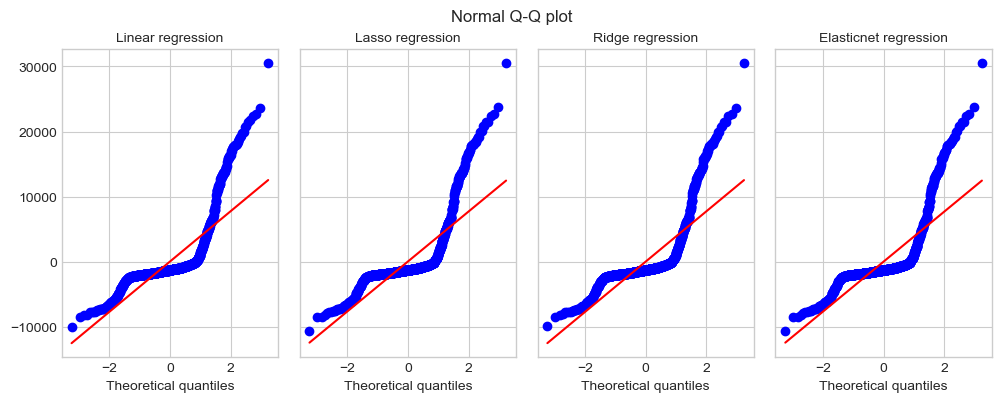

In [179]:
from scipy.stats import probplot

def quantile_plot(model, X, y, ax):
    ypred = model[-1].predict(X)
    loss = y - ypred
    probplot(loss, dist="norm", plot=ax)
    ax.set_title(f"{model[0]}", size=10)
    ax.set_ylabel(ax.get_ylabel(), visible=False)


fig, axes = plt.subplots(1, 4, sharey=True, figsize=(12, 4), gridspec_kw={"wspace": 0.1}, frameon=True)
quantile_plot(("Linear regression", best_lr), X_train, y_train, ax=axes[0])
quantile_plot(("Lasso regression", best_l1), X_train, y_train, ax=axes[1])
quantile_plot(("Ridge regression", best_l2), X_train, y_train, ax=axes[2])
quantile_plot(("Elasticnet regression", best_elastic_net), X_train, y_train, ax=axes[3])
fig.suptitle("Normal Q-Q plot")
plt.show()